# Hardbrücke

## Quelle

https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke

In [1]:
import sys
print(sys.version)

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]


In [2]:
#!pip install scikit-learn==1.0.1

In [3]:
import pickle
import zipfile

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics
import sklearn
print(sklearn.__version__)


1.5.1


In [6]:
import warnings
warnings.filterwarnings("ignore")

## Get Data
Lade historische Daten herunter

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [8]:
#import os

In [9]:
#os.listdir('/content/gdrive/MyDrive/ColabNotebooks/hardbruecke')

In [10]:
filepaths = [
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2020.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2021.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2022.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2023.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2024.csv',
    'https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2025.csv',
]

In [11]:
hb = pd.DataFrame()
print("shape df: ", hb.shape)
for file in filepaths:
  print(file)
  hb = hb._append(pd.read_csv(file))
  print("shape df: ", hb.shape)

shape df:  (0, 0)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2020.csv
shape df:  (714681, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2021.csv
shape df:  (1440537, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2022.csv
shape df:  (2184165, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2023.csv
shape df:  (2889304, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2024.csv
shape df:  (3594182, 4)
https://data.stadt-zuerich.ch/dataset/vbz_frequenzen_hardbruecke/download/frequenzen_hardbruecke_2025.csv
shape df:  (4323409, 4)


In [12]:
hb = hb.drop_duplicates()
hb

,In,Out,Timestamp,Name
0,1,0,2020-01-01T23:55:00,Ost-Nord total
1,2,5,2020-01-01T23:50:00,Ost-Nord total
2,1,0,2020-01-01T23:45:00,Ost-Nord total
3,1,4,2020-01-01T23:40:00,Ost-Nord total
4,1,0,2020-01-01T23:35:00,Ost-Nord total
...,...,...,...,...
729222,4,2,2025-12-31T23:55:00,Ost-VBZ Total
729223,4,1,2025-12-31T23:55:00,West-Nord total
729224,16,12,2025-12-31T23:55:00,West-SBB total
729225,0,9,2025-12-31T23:55:00,West-Süd total


Test, ob es dem Modell hilft, wenn die Anzahl der Personen der vorherigen Periode mit gegeben wird (in der Regel 5 Minuten vorher).

In [13]:
def add_previous_count(df):
  df = df.sort_values(['name_cat','direction_cat','Timestamp'])
  df['count_previous'] = df['count'].shift(1, fill_value= 0)
  # set first values to
  df.loc[df['Timestamp']=='2020-01-01 00:00:00','count_previous'] = 0
  return df
#test = add_previous_count(hb2)

## Datenaufbereitung
- Codierung Eingangsnamen mit Zahlen
- bisschen umformatieren

In [14]:
# data from: https://github.com/alexanderguentert/predict_hardbruecke/blob/main/streamlit_app.py

names = {
    'Ost-Süd total': 0,
    'Ost-Sd total': 0,  # alias, as seen in api query (2020 and 2021)
    'Ost-Nord total': 1,
    'Ost-SBB total': 2,
    'West-SBB total': 3,
    'West-Süd total': 4,
    'West-Sd total': 4,  # alias, as seen in api query (2020 and 2021)
    'Ost-VBZ Total': 5,
    'West-Nord total': 6,
    'West-VBZ total': 7,
}

def data_preparation(df, names): #, date):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # df = df.merge(pd.DataFrame({'Timestamp': create_date_range(date)}), how='right')
    # df[['In', 'Out']] = df[['In', 'Out']].fillna(9999)  # fill with dummy value

    df = df.set_index(['Timestamp', 'Name']).stack().reset_index()
    df = df.rename(columns={'level_2': 'direction', 0: 'count'})

    df.loc[df['Name'].isna(), 'count'] = np.nan  # remove dummy value

    df['direction'] = df['direction'].astype('category')
    df['year'] = df['Timestamp'].dt.year
    df['hour'] = df['Timestamp'].dt.hour
    df['weekday'] = df['Timestamp'].dt.weekday
    df['minute'] = df['Timestamp'].dt.minute
    df['month'] = df['Timestamp'].dt.month
    df['day'] = pd.to_datetime(df['Timestamp'].dt.date)
    df['direction_cat'] = df['direction'].replace({'In': 0, 'Out': 1})
    df['name_cat'] = df['Name'].replace(names)

    #df = add_previous_count(df)

    return df

In [15]:
hb2 = data_preparation(hb, names)

In [16]:
hb2

,Timestamp,Name,direction,count,year,hour,weekday,minute,month,day,direction_cat,name_cat
0,2020-01-01 23:55:00,Ost-Nord total,In,1.0,2020,23,2,55,1,2020-01-01,0,1
1,2020-01-01 23:55:00,Ost-Nord total,Out,0.0,2020,23,2,55,1,2020-01-01,1,1
2,2020-01-01 23:50:00,Ost-Nord total,In,2.0,2020,23,2,50,1,2020-01-01,0,1
3,2020-01-01 23:50:00,Ost-Nord total,Out,5.0,2020,23,2,50,1,2020-01-01,1,1
4,2020-01-01 23:45:00,Ost-Nord total,In,1.0,2020,23,2,45,1,2020-01-01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8642401,2025-12-31 23:55:00,West-SBB total,Out,12.0,2025,23,2,55,12,2025-12-31,1,3
8642402,2025-12-31 23:55:00,West-Süd total,In,0.0,2025,23,2,55,12,2025-12-31,0,4
8642403,2025-12-31 23:55:00,West-Süd total,Out,9.0,2025,23,2,55,12,2025-12-31,1,4
8642404,2025-12-31 23:55:00,West-VBZ total,In,11.0,2025,23,2,55,12,2025-12-31,0,7


## Desskriptive Statistik
Plots mit Verteilungen

<Axes: ylabel='Frequency'>

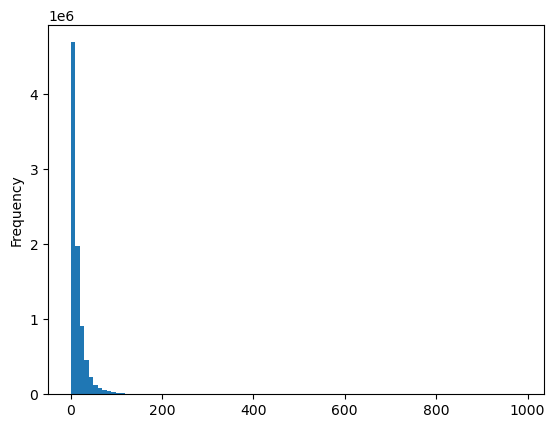

In [17]:
hb2['count'].plot(kind='hist', bins=100)

<Axes: xlabel='count', ylabel='direction'>

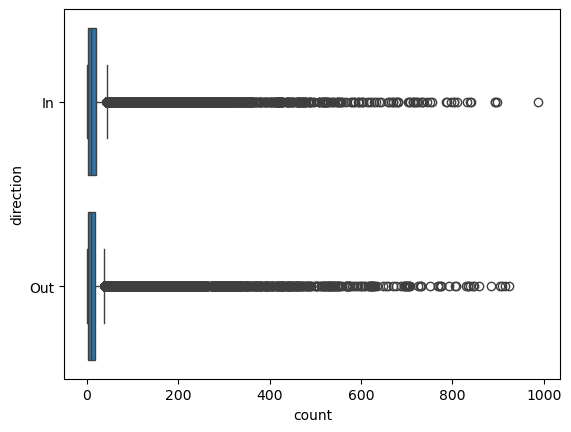

In [18]:
sns.boxplot(data=hb2,x='count',y='direction')

Es gibt einige sehr grosse Ausreisser. Die sollte man besser aus den Trainingsdaten entfernen. Ganz grob, alles über 500.

In [19]:
hb2 = hb2[hb2['count']<500]

<Axes: ylabel='Frequency'>

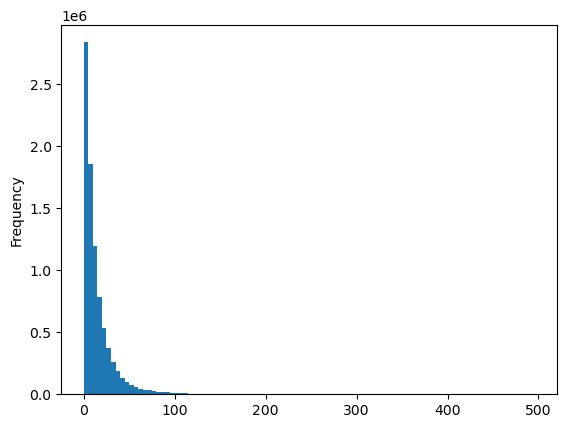

In [20]:
hb2['count'].plot(kind='hist', bins=100)

In [21]:
hb2['Name'].value_counts()

Name
Ost-SBB total      1116986
Ost-Süd total      1114792
Ost-Nord total     1113774
West-SBB total     1099556
West-Süd total     1078374
West-Nord total    1055732
Ost-VBZ Total      1046060
West-VBZ total     1016934
Name: count, dtype: int64

In [22]:
hb2['direction'].value_counts()

direction
In     4321117
Out    4321091
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Ost-Nord total'),
  Text(1, 0, 'Ost-SBB total'),
  Text(2, 0, 'Ost-Süd total'),
  Text(3, 0, 'Ost-VBZ Total'),
  Text(4, 0, 'West-Nord total'),
  Text(5, 0, 'West-SBB total'),
  Text(6, 0, 'West-Süd total'),
  Text(7, 0, 'West-VBZ total')])

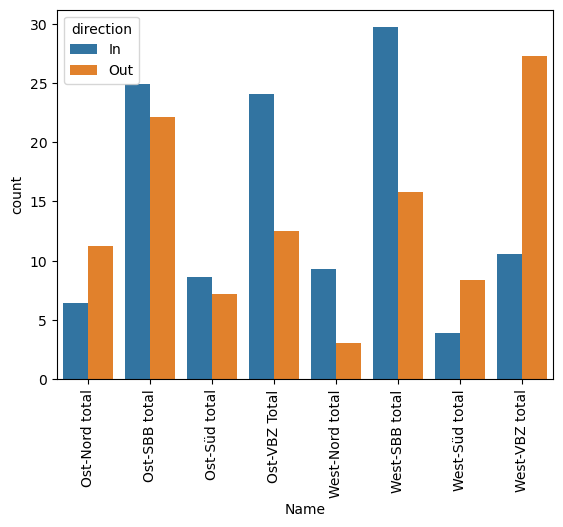

In [23]:
name = hb2.groupby(['Name','direction'])['count'].mean()
sns.barplot(data=name.reset_index(),x='Name',y='count',hue='direction')
plt.xticks(rotation = 90)

<Axes: xlabel='month', ylabel='count'>

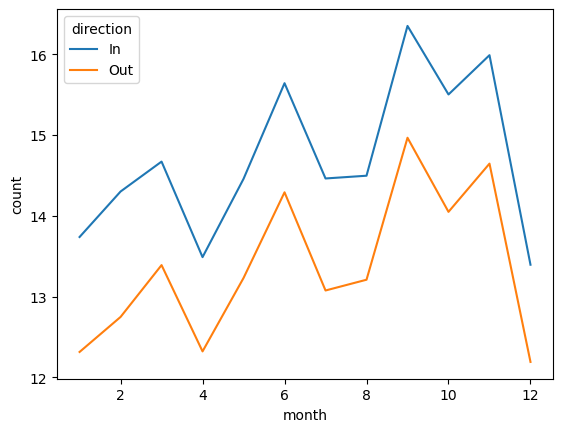

In [24]:
months = hb2.groupby(['month','direction'])['count'].mean()
sns.lineplot(data=months.reset_index(),x='month',y='count',hue='direction')

<Axes: xlabel='hour', ylabel='count'>

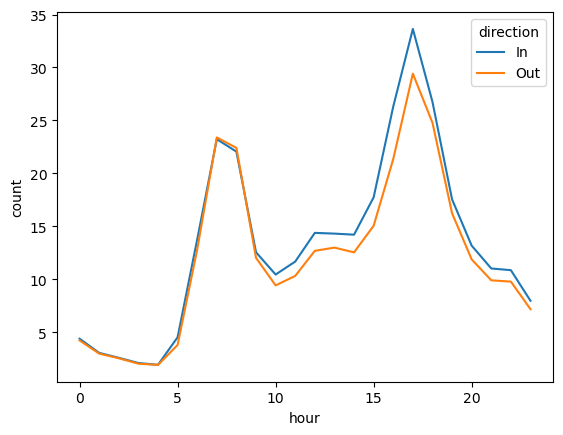

In [25]:
hour = hb2.groupby(['hour','direction'])['count'].mean()
sns.lineplot(data=hour.reset_index(),x='hour',y='count',hue='direction')

<Axes: xlabel='minute', ylabel='count'>

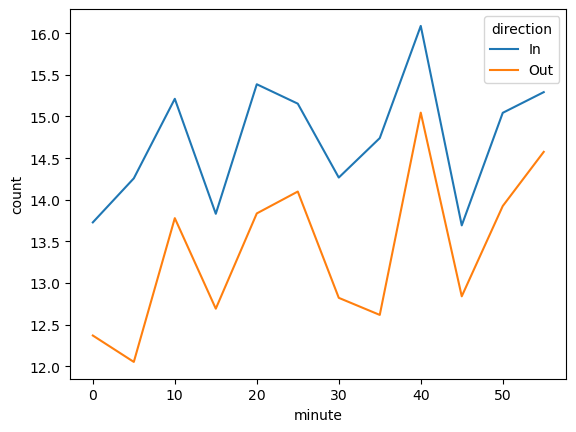

In [26]:
minute = hb2.groupby(['minute','direction'])['count'].mean()
sns.lineplot(data=minute.reset_index(),x='minute',y='count',hue='direction')

<Axes: xlabel='weekday', ylabel='count'>

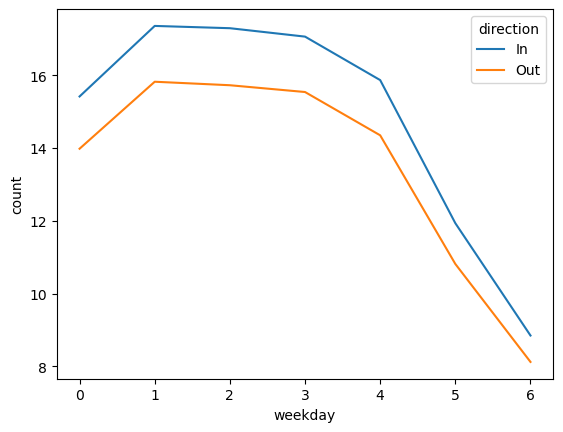

In [27]:
weekday = hb2.groupby(['weekday','direction'])['count'].mean()
sns.lineplot(data=weekday.reset_index(),x='weekday',y='count',hue='direction')

<Axes: xlabel='year', ylabel='count'>

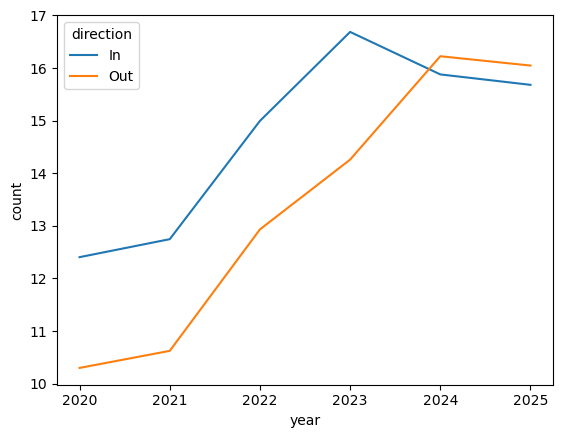

In [28]:
year = hb2.groupby(['year','direction'])['count'].mean()
sns.lineplot(data=year.reset_index(),x='year',y='count',hue='direction')

Das ist auffällig. Ab 2024 sind die Unterschiede zwischen In und Out viel kleiner. Das ist plausibler. Den grundsätzlich sollten die Zahlen in etwa gleich sein. Denn alle Personen, die die Haltestelle betreten, sollten sie auch irgendwann wieder verlassen.Die Anpassungen von VBZ haben anscheinend etwas gebraucht.

# Machine Learning

In [29]:
XList=[
  'year',
  'hour',
  'weekday',
  'minute',
  'month',
  'direction_cat',
  'name_cat',
  #'count_previous',
  #'holiday',
]
y='count'

In [30]:
if True:
  hb2X=hb2[XList]
  hb2Y=hb2[y]
  X_train, X_test, y_train, y_test = train_test_split(hb2X, hb2Y)

In [31]:
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
  regressor = model
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)
  metric_df = pd.DataFrame(
    index=['Mean Absolute Error','Mean Squared Error','Root Mean Squared Error'],
    data={'value':[metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred))]})
  return {
      'model': regressor,
      'y_pred': y_pred,
      'metrics': metric_df
  }

### Berechne Produktives Modell

In [32]:
if True:
    reg = fit_and_evaluate(RandomForestRegressor(n_estimators=10,n_jobs=-1,
                                                max_depth=18,
                                                min_samples_split=20,
                                                min_samples_leaf=20,
                                                ),
                          X_train, X_test, y_train, y_test)
    print(reg['metrics'])

                             value
Mean Absolute Error       5.069722
Mean Squared Error       88.433162
Root Mean Squared Error   9.403891


Zum Vergleich: Zahlen vom letzten Durchgang

|Kennzahl|Wert 2024|Wert 2025|
|-|-|-|
|Mean Absolute Error|4.700644|4.891510|
|Mean Squared Error|73.322774|80.996926|
|Root Mean Squared Error|8.562872|8.999829|

Evaluation

Text(0.5, 1.0, 'Vergeleich Prognose und echter Wert (inkl. Ideallinie)')

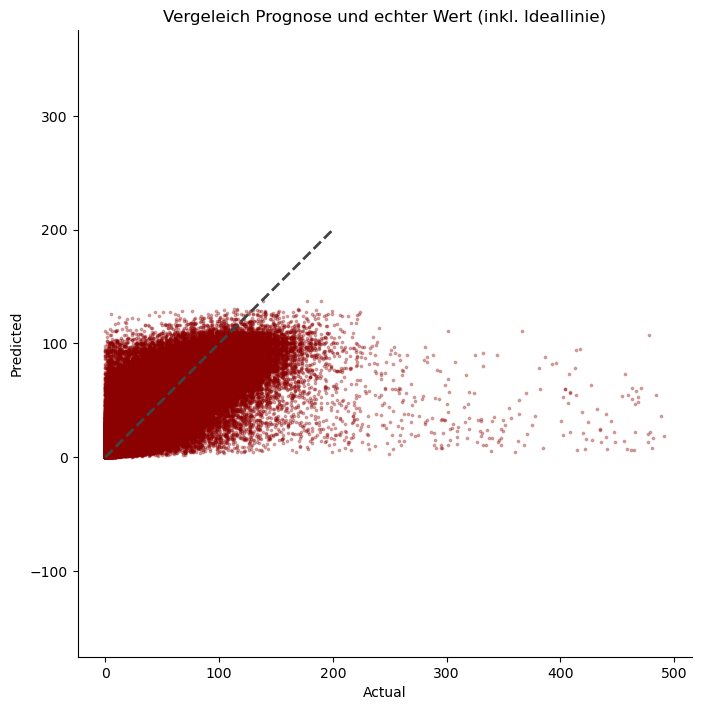

In [33]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':reg['y_pred']})
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
plt.title('Vergeleich Prognose und echter Wert (inkl. Ideallinie)')

[Text(0.5, 1.0, 'feature_importances')]

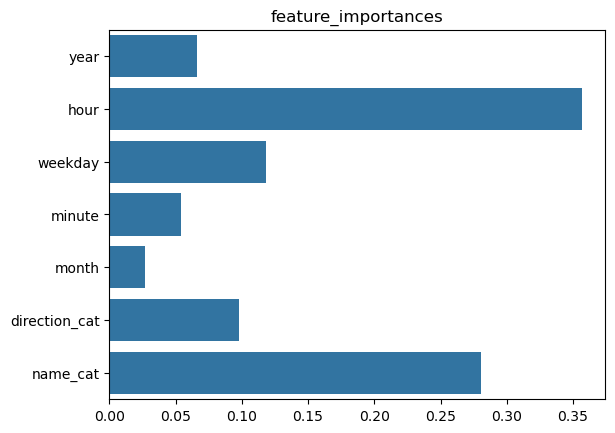

In [34]:
sns.barplot(x=reg['model'].feature_importances_,
            y=XList).set(title='feature_importances')

Lokal abspeichern.

In [35]:
today = pd.Timestamp.today().strftime('%Y-%m-%d')
model_path = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/'
model_path = '../models/'

In [36]:
#filename = '{model_path}{today}_RandomForestRegressor.sav'.format(today=today, model_path=model_path)
#pickle.dump(reg['model'], open(filename, 'wb'))

# Modell serialisieren und direkt in die ZIP-Datei schreiben
zip_filename = '{model_path}{today}_RandomForestRegressor.zip'.format(today=today, model_path=model_path)
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Modell serialisieren
    serialized_model = pickle.dumps(reg['model'])
    # In die ZIP-Datei schreiben (Dateiname innerhalb der ZIP-Datei angeben)
    zipf.writestr('RandomForestRegressor.sav', serialized_model)

In [46]:
# Modell direkt aus der ZIP-Datei laden
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    # Aus der ZIP-Datei lesen
    serialized_model = zipf.read('RandomForestRegressor.sav')
    # Modell deserialisieren
    loaded_model = pickle.loads(serialized_model)

### Alternative Modelle
Vergleich mit ein paar alternativen Modellen, die sich einigermassen schnell berechnen lassen.

In [37]:
models = {
          'DecisionTree': DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5),
          'RandomForest': RandomForestRegressor(n_estimators=12,n_jobs=-1,max_depth=15, min_samples_leaf=50) ,
          'GradientBoosting': GradientBoostingRegressor(n_estimators=10, min_samples_leaf=10, max_depth=20),
          'LinearRegression': LinearRegression(),
          # 'CatBoost': CatBoostRegressor(n_estimators=10,loss_function = 'RMSE', eval_metric = 'RMSE',cat_features = ['name_cat'])
          #'Support Vector Regression': SVR(kernel = 'rbf'), # vorsicht langsam

}

In [38]:
output = {}
for m in models:
  print('\n'+m)
  output[m] = fit_and_evaluate(models[m], X_train, X_test, y_train, y_test)
  print(output[m]['metrics'])



DecisionTree
                             value
Mean Absolute Error       5.340706
Mean Squared Error       97.456157
Root Mean Squared Error   9.871989

RandomForest
                             value
Mean Absolute Error       5.290073
Mean Squared Error       95.920559
Root Mean Squared Error   9.793904

GradientBoosting
                              value
Mean Absolute Error        6.381098
Mean Squared Error       114.456479
Root Mean Squared Error   10.698433

LinearRegression
                              value
Mean Absolute Error       11.224125
Mean Squared Error       304.151436
Root Mean Squared Error   17.439938


Random Forest schneidet am besten ab, produziert aber ein riesiges Modell. Decision Tree ist nicht viel schlechter, aber einiges kleiner. Gradient Boosting scheint sich nicht zu lohnen (gilt auch für LightGBM)

Text(0.5, 1.0, 'DecisionTree')

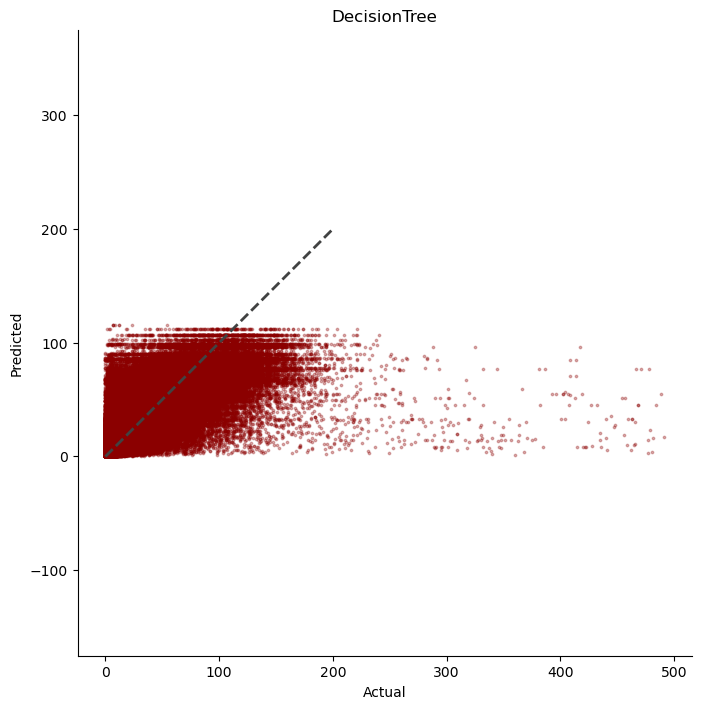

In [39]:
model_name = 'DecisionTree'
df=pd.DataFrame({'Actual':y_test, 'Predicted':output[model_name]['y_pred']})
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7).set(title=model_name)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
plt.title(model_name)

<Axes: >

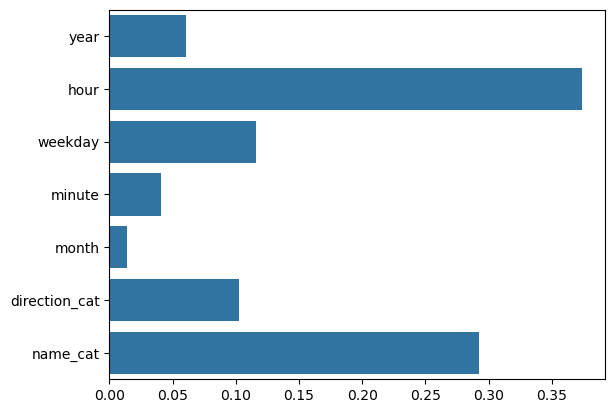

In [40]:
sns.barplot(x=output[model_name]['model'].feature_importances_,
            y=XList)

Text(0.5, 1.0, 'RandomForest')

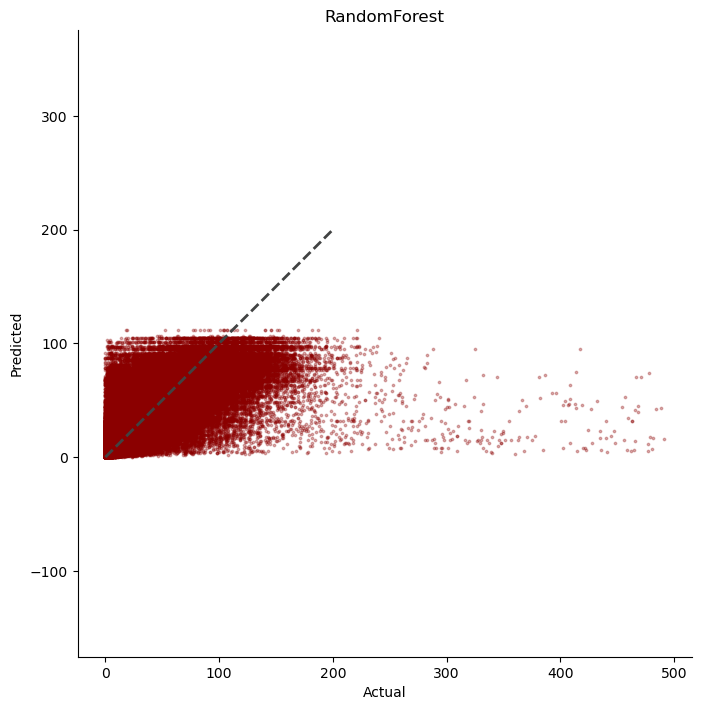

In [41]:
model_name = 'RandomForest'
df=pd.DataFrame({'Actual':y_test, 'Predicted':output[model_name]['y_pred']})
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
#plt.xscale('log')
#plt.yscale('log')
plt.title(model_name)

<Axes: >

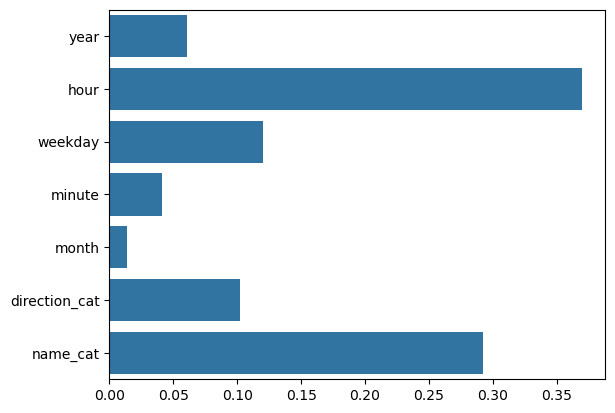

In [42]:
sns.barplot(x=output[model_name]['model'].feature_importances_,
            y=XList)

<Axes: title={'center': 'Distribution of Errors'}, ylabel='Frequency'>

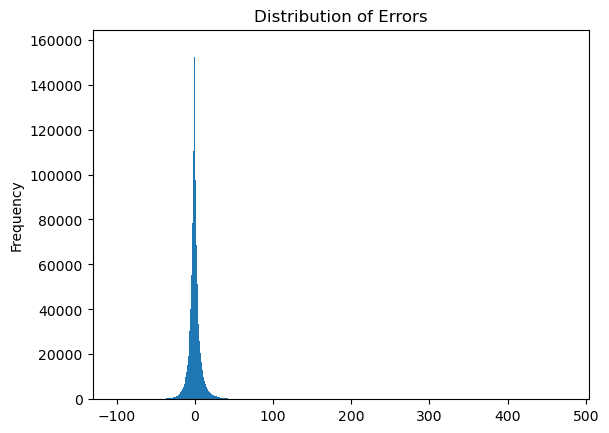

In [43]:
(df['Actual']-df['Predicted']).plot(kind='hist', bins=1000, title='Distribution of Errors')

## Fehlerverteilung
Schauen, wie sich die Fehler des Modells verteilen.

In [44]:
hb2['predicted'] = reg['model'].predict(hb2[XList])

In [45]:
hb2['error'] = hb2['count'] - hb2['predicted']

<Axes: title={'center': 'Distribution of Errors'}, ylabel='Frequency'>

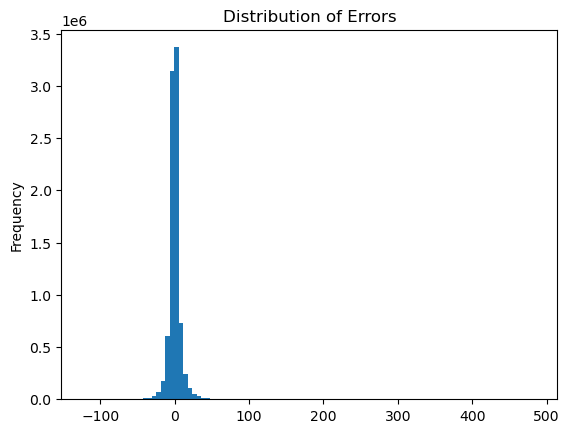

In [46]:
hb2['error'].plot(kind='hist', bins=100, title='Distribution of Errors')

<Axes: xlabel='error', ylabel='Count'>

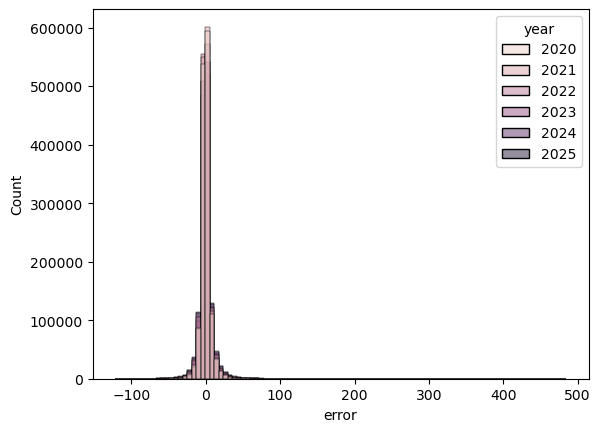

In [47]:
sns.histplot(hb2, x='error', hue='year', bins=100)

In [48]:
categories = ['Name', 'direction', 'year', 'month', 'weekday']

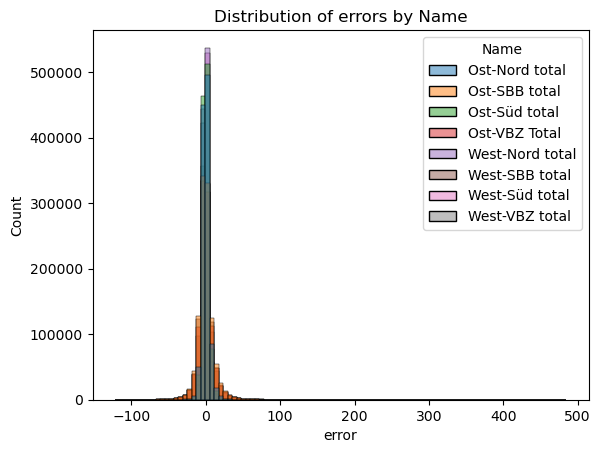

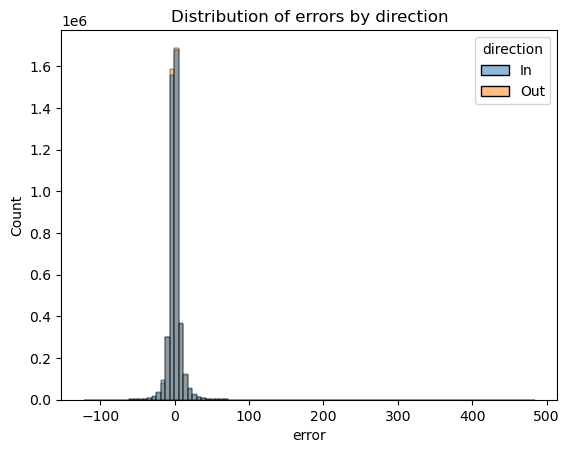

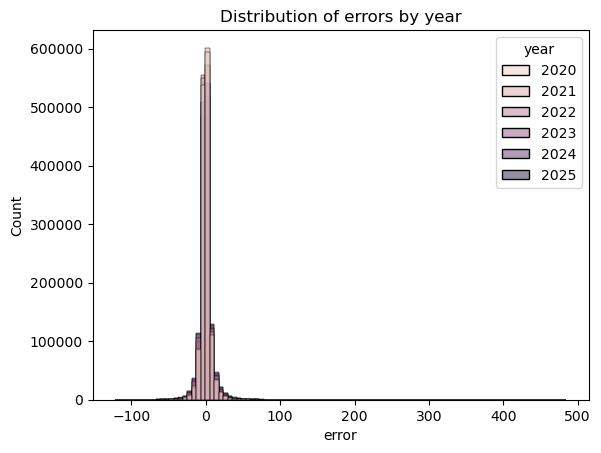

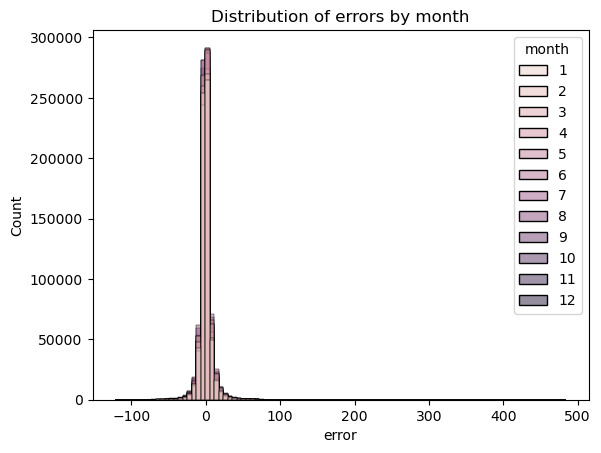

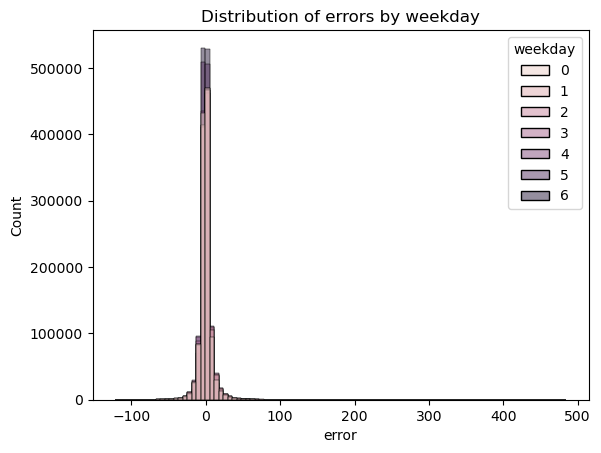

In [49]:
for elem in categories:
    sns.histplot(hb2, x='error', hue=elem, bins=100).set_title("Distribution of errors by "+elem)
    plt.show()

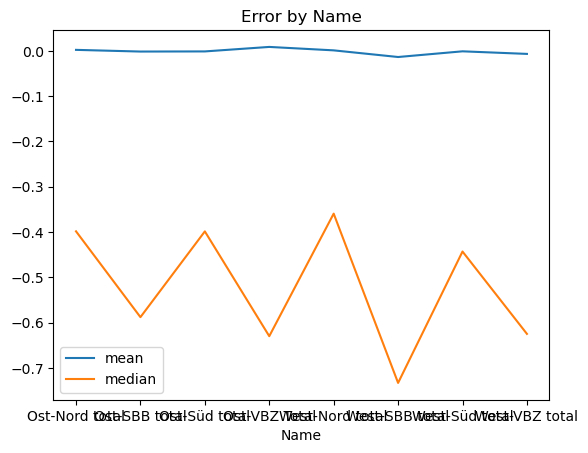

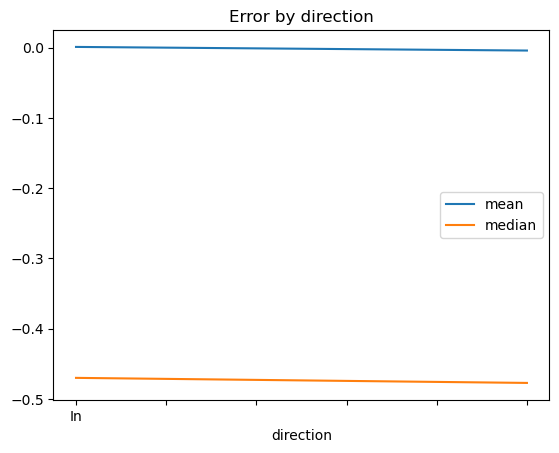

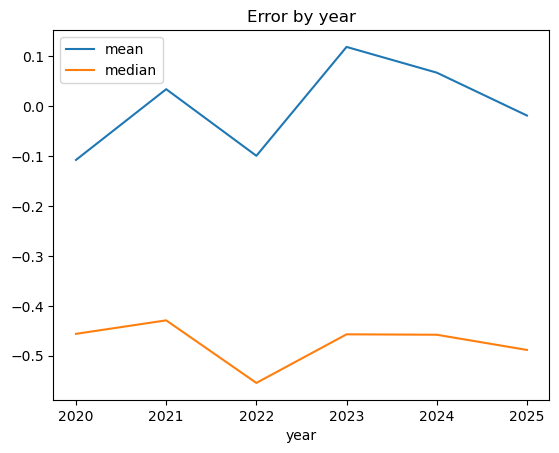

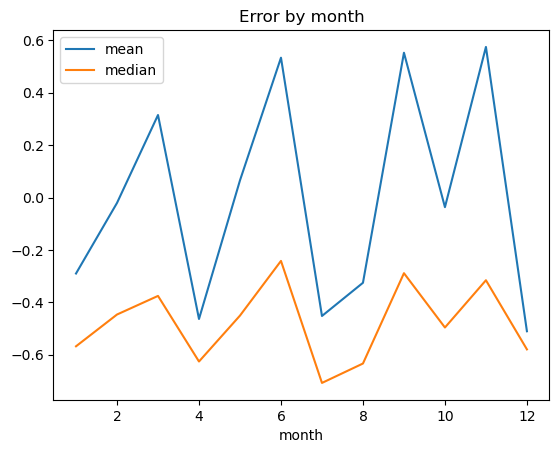

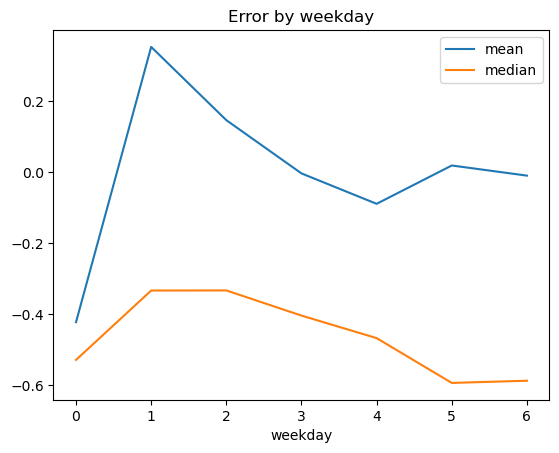

In [50]:
for elem in categories:
    hb2.groupby(elem).agg(
        mean = ('error', 'mean'),
        median = ('error', 'median'),
        #std = ('error', 'std'),
    ).plot(title="Error by "+elem)
    plt.show()

In [51]:
hb2['error'].describe()

count    8.642208e+06
mean    -1.673439e-03
std      9.216441e+00
min     -1.219237e+02
25%     -3.022448e+00
50%     -4.733678e-01
75%      2.358223e+00
max      4.842269e+02
Name: error, dtype: float64

In [53]:
worst1000 = hb2.sort_values(by='error', ascending=False).loc[:1000,:]

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
if False:
    scores = cross_val_score(DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5),
                            hb2[XList], hb2[y], cv=5,scoring = 'neg_mean_absolute_error')
    print(scores)
    print("neg_mean_absolute_error %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## Production Model

In [ ]:
if False:
    regressor = DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5)
    regressor.fit(hb2[XList], hb2[y])

In [ ]:

filename = '/content/gdrive/MyDrive/ColabNotebooks/hardbruecke/models/2022-01-05_DecisionTreeRegressor.sav'
#pickle.dump(regressor, open(filename, 'wb'))

## lgbm

In [ ]:
import lightgbm as lgb

In [ ]:
categorical_features = ['direction_cat','name_cat','weekday']

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train
 ,feature_name = XList
 , categorical_feature = categorical_features
)

In [ ]:
params = {
 'task': 'train'
 #, 'boosting_type': 'dart'
 #, 'max_depth' : 25
 , 'objective': 'regression'
 #, 'num_leaves':60
 #, 'num_class': num_of_classes
 , 'metric': 'mse' #'mae' #'rmsle'
 #,'min_data_in_leaf': 40
 #,'num_trees':100 # default 100
 #, 'min_data': 5
 #, 'verbose': -1
}
gbm = lgb.train(params, lgb_train)

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.



In [ ]:
y_pred = gbm.predict(X_test)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred) )
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#print('R2 Score: ',metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 5.012408735532897
Mean Squared Error: 78.0878296307074
Root Mean Squared Error: 8.836731841054554


Text(0.5, 1.0, 'LightGBM')

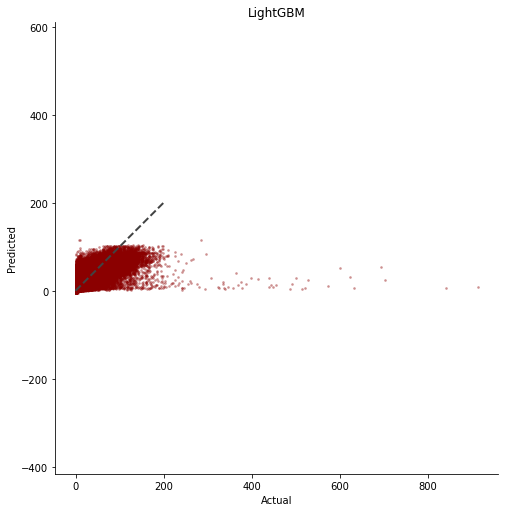

In [ ]:
model_name = 'LightGBM'
df=pd.DataFrame({'Actual':y_test, 'Predicted':gbm.predict(X_test)})
# vorsicht: es wird nur ein Ausschnitt der Daten angezeigt
sns.lmplot(x='Actual', y='Predicted', data=df,fit_reg=False,
           scatter_kws={"color":"darkred","alpha":0.3,"s":3},height=7)
# add y=x line
plt.plot([0,200],[0,200], lw=2, color='#414242', linestyle='dashed') # ideallinie wo predicted = actual
plt.axis('equal')
#plt.xscale('log')
#plt.yscale('log')
plt.title(model_name)